In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
torch.manual_seed(42)

In [16]:
import os 
path = '/Volumes/Sid_Drive/mnist/'

if os.path.exists(path):
    prefix = path
else:
    prefix = ''

### Config Stuff

In [4]:
# model hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 5

In [5]:
class LayerConfig:
    def __init__(self, name, input_dim):
        self.name = name
        self.input_dim = input_dim

# Create instances for each layer
fc1_config = LayerConfig('fc1', 256)
fc2_config = LayerConfig('fc2', 128)
fc3_config = LayerConfig('fc3', 10)
encoder_config = LayerConfig('encoder', 2304)
decoder_config = LayerConfig('decoder', 128)

### Load in Data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
from tqdm import tqdm

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalization for validation
transform_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_name = 'FashionMNIST'

# Load CIFAR10 dataset
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

# Load CIFAR100 dataset
# train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
# val_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_val)

# Load EMNIST dataset
# train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True, transform=transform_train)
# val_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True, transform=transform_val)

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root=f'{prefix}data', train=True, download=True, transform=transform_train)
val_dataset = datasets.FashionMNIST(root=f'{prefix}data', train=False, download=True, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### Display the Image

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN

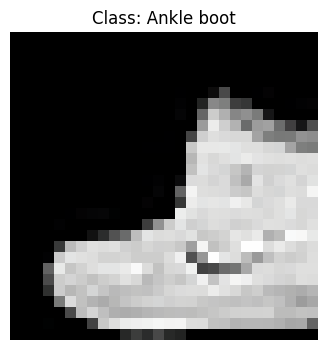

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Undo normalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    
    # Convert to numpy and transpose from (C,H,W) to (H,W,C)
    img = img.numpy().transpose((1, 2, 0))
    
    # Unnormalize
    img = std * img + mean
    
    # Clip values to be between 0 and 1
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.axis('off')

# Get a random image from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# # Display a single image
# plt.figure(figsize=(4, 4))
# imshow(images[0])
# plt.title(f'Class: {labels[0].item()}')
# plt.show()

# If you want to display the actual class name
classes = train_dataset.classes  # Get class names
plt.figure(figsize=(4, 4))
imshow(images[0])
plt.title(f'Class: {classes[labels[0].item()]}')
plt.show()

In [8]:
from structs.models import MNISTModel, ColoredMNISTModel
# load in trained mnist model 
model = ColoredMNISTModel()
model.load_state_dict(torch.load('models/colored_mnist_model.pth'))

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_13469/3449977505.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/colo

<All keys matched successfully>

In [9]:
model.clear_cache()
model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()

accuracy = total_correct / len(val_loader.dataset)
print(f'Validation accuracy: {accuracy:.2f}%')

/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN

Validation accuracy: 0.03%


### Get Activations

In [10]:
selected_layer_config = fc2_config

In [11]:
from tqdm import tqdm 
import matplotlib.pyplot as plt

model.clear_cache()
model.eval()
with torch.no_grad():
    for images, labels in tqdm(train_loader):
        outputs = model(images)

  0%|          | 0/938 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /opt/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /opt/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/lib/python3.11/site-packages/torchvision/im

In [13]:
num_images = len(train_loader.dataset)
print(f'Number of images in the train_loader: {num_images}')

Number of images in the train_loader: 60000


In [14]:
analysis_activations = model.get_cached_activations(selected_layer_config.name)
analysis_activations.shape

torch.Size([60000, 128])

In [17]:
torch.save(analysis_activations, f'{prefix}embeddings/mnist_{selected_layer_config.name}_{data_name}.pth')

### Sae Analysis

In [ ]:
from structs.models import SimpleSAE, EnhancedSAE

input_dim = selected_layer_config.input_dim
hidden_dim = 2304
sae = EnhancedSAE(input_dim=input_dim, hidden_dim=hidden_dim, l1_coeff=0.01)
sae.load_state_dict(torch.load('models/mnist_sae_colored.pth'))

In [ ]:
analysis_activations = torch.load(f'{prefix}embeddings/mnist_{fc1_config.name}_{data_name}.pth')
analysis_loader = DataLoader(analysis_activations, batch_size=batch_size, shuffle=False) # do not shuffle

analysis_activations.shape

In [ ]:
# pass the activations through the SAE and save the intermediary activations 
sae.clear_cache()
sae.eval()
with torch.no_grad():
    for activations in tqdm(analysis_loader):
        encoded, decoded = sae(activations, cache_activations=True)

In [ ]:
sae_activations = sae.get_cached_activations('encoder')
torch.save(sae_activations, f'{prefix}embeddings/mnist_encoder_{data_name}.pth')
sae_activations.shape

#### Second SAE

In [20]:
selected_layer_config = encoder_config

In [ ]:
from structs.models import SimpleSAE, EnhancedSAE
selected_layer_config = encoder_config

input_dim = selected_layer_config.input_dim
hidden_dim = 2304
meta_sae = EnhancedSAE(input_dim=input_dim, hidden_dim=hidden_dim, l1_coeff=0.01)
meta_sae.load_state_dict(torch.load('models/mnist_meta_sae_colored.pth'))

In [ ]:
meta_analysis_activations = torch.load(f'{prefix}embeddings/mnist_encoder_{data_name}.pth')
meta_analysis_loader = DataLoader(meta_analysis_activations, batch_size=batch_size, shuffle=False) # do not shuffle

meta_analysis_activations.shape

In [ ]:
# pass the activations through the SAE and save the intermediary activations 
meta_sae.clear_cache()
meta_sae.eval()
with torch.no_grad():
    for activations in tqdm(meta_analysis_loader):
        encoded, decoded = meta_sae(activations, cache_activations=True)

In [ ]:
meta_sae_activations = meta_sae.get_cached_activations('encoder')
meta_sae_activations.shape

In [46]:
torch.save(meta_sae_activations, f'{prefix}embeddings/mnist_meta_encoder_{data_name}.pth')

### Top 10 images

In [51]:
sae_activations = torch.load(f'{prefix}embeddings/mnist_encoder_depth_1_{data_name}.pth')

In [52]:
# transpose is to make it by neuron as opposed to by sample 
transposed = sae_activations.T
transposed.shape

In [53]:
max_10_indices_per_neuron = torch.argsort(transposed, descending=True, dim=1)[:, :10]
max_10_indices_per_neuron_value = torch.gather(transposed, 1, max_10_indices_per_neuron)

### Analyze Max Activations

In [4]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_activation_distributions(tensor, max_10_activations, depth):
    """
    Plot distributions of activations in a tensor and its top-10 values per neuron.
    
    Args:
        tensor: torch.Tensor of shape [neuron_count, sample_count]
        max_10_activations: torch.Tensor of shape [neuron_count, 10]
    """
    # Convert tensors to numpy for plotting
    all_activations = tensor.cpu().numpy().flatten()
    max_activations = max_10_activations.cpu().numpy().flatten()
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Distribution of all activations
    sns.histplot(all_activations, bins=100, kde=True, ax=ax1)
    ax1.set_title('Distribution of All Activations')
    ax1.set_xlabel('Activation Value')
    ax1.set_ylabel('Count')
    
    # Add mean and median lines
    mean_all = np.mean(all_activations)
    median_all = np.median(all_activations)
    ax1.axvline(mean_all, color='r', linestyle='--', label=f'Mean: {mean_all:.2f}')
    ax1.axvline(median_all, color='g', linestyle='--', label=f'Median: {median_all:.2f}')
    ax1.legend()
    
    # Plot 2: Distribution of top-10 activations per neuron
    sns.histplot(max_activations, bins=50, kde=True, ax=ax2)
    ax2.set_title('Distribution of Top-10 Activations per Neuron')
    ax2.set_xlabel('Activation Value')
    ax2.set_ylabel('Count')
    
    # Add mean and median lines
    mean_max = np.mean(max_activations)
    median_max = np.median(max_activations)
    ax2.axvline(mean_max, color='r', linestyle='--', label=f'Mean: {mean_max:.2f}')
    ax2.axvline(median_max, color='g', linestyle='--', label=f'Median: {median_max:.2f}')
    ax2.legend()
    
    # Add summary statistics
    plt.figtext(0.02, 0.02, f"""
    All Activations Stats:
    Mean: {mean_all:.2f}
    Median: {median_all:.2f}
    Std: {np.std(all_activations):.2f}
    
    Top-10 Activations Stats:
    Mean: {mean_max:.2f}
    Median: {median_max:.2f}
    Std: {np.std(max_activations):.2f}
    """, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'plots/encoder_{data_name}_depth_{depth}.png')

# Example usage:
# tensor = your_tensor  # shape: [2304, 112800]
# max_10_activations = your_max_10_tensor  # shape: [2304, 10]
# plot_activation_distributions(transposed, max_10_indices_per_neuron_value)

### Analyze Image

In [25]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import os

def plot_indices_save(indices, filepath, filename, neuron_idx):
    count = 0

    idx_tensor = []
    for i, idx in enumerate(indices):
        activation_value = transposed[neuron_idx][idx]
        if transposed[neuron_idx][idx] == 0:
            # print('skipped idx', idx)
            continue
        count += 1

        img = train_dataset.data[idx]
        img_filename = f'{i}_{activation_value:.2f}.png'
        mpimg.imsave(img_filename, img)
        idx_tensor.append(idx)

        
    os.makedirs(filepath, exist_ok=True)
    os.makedirs(f'{filepath}/{count}_{filename}', exist_ok=True)
    for file in os.listdir("."):
        if file.endswith(".png"):
            os.rename(file, f'{filepath}/{count}_{filename}/{file}')
    
    import csv
    with open(f'{filepath}/{count}_{filename}/indexes_and_activations.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Index", "Activation Value"])  # header
        for idx, activation_value in zip(idx_tensor, [transposed[neuron_idx][idx].item() for idx in idx_tensor]):
            writer.writerow([idx.item(), activation_value])
    
    

In [65]:
from tqdm import tqdm
import os 

filepath = f'docs/neuron_{data_name}_test'
os.makedirs(filepath, exist_ok=True)

for i in tqdm(range(len(max_10_indices_per_neuron)), desc="Plotting neurons"):
    indices = max_10_indices_per_neuron[i]
    plot_indices_save(indices, filepath, f'neuron_{i}_plots', i)  # Save individual plots if needed


### Analyze Function

In [18]:
from structs.models import SimpleSAE, EnhancedSAE
activations = torch.load(f'embeddings/mnist_fc2_{data_name}.pth')

for depth in range(1,10):
    data_loader = torch.utils.data.DataLoader(activations, batch_size=64, shuffle=False)

    if depth == 1:
        model = SimpleSAE(input_dim=fc1_config.input_dim, hidden_dim=2304, l1_coeff=0.01)
        model.load_state_dict(torch.load(f'models/mnist-colored_sae_MNIST_depth_{depth}.pth'))
    else:
        model = SimpleSAE(input_dim=encoder_config.input_dim, hidden_dim=encoder_config.input_dim, l1_coeff=0.01)
        model.load_state_dict(torch.load(f'models/mnist-colored_sae_MNIST_depth_{depth}.pth'))
    
    model.clear_cache()
    model.eval()
    with torch.no_grad():
        for activations in tqdm(data_loader):
            encoded, decoded = model(activations, cache_activations=True)

    activations = model.get_cached_activations('encoder')
    torch.save(activations, f'{prefix}embeddings/mnist_encoder_depth_{depth}_{data_name}.pth')

/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_13469/3539037891.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations = torch.load(f'embeddings/mnist_f

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings/mnist_fc2_FashionMNIST.pth'

In [27]:
from tqdm import tqdm
import os 

def plot_controller(max_10_indices_per_neuron, depth):
    filepath = f'docs/neuron_{data_name}_depth_{depth}'
    os.makedirs(filepath, exist_ok=True)

    for i in tqdm(range(len(max_10_indices_per_neuron)), desc="Plotting neurons"):
        indices = max_10_indices_per_neuron[i]
        plot_indices_save(indices, filepath, f'neuron_{i}_plots', i)  # Save individual plots if needed

In [28]:
from tqdm import tqdm
import torch 
import os

for depth in tqdm(range(1, 10), desc="Analyzing depths"):
    activations = torch.load(f'{prefix}embeddings/mnist_encoder_depth_{depth}_{data_name}.pth')
    transposed = activations.T
    max_10_indices_per_neuron = torch.argsort(transposed, descending=True, dim=1)[:, :10]
    max_10_indices_per_neuron_value = torch.gather(transposed, 1, max_10_indices_per_neuron)
    
    # plot_activation_distributions(transposed, max_10_indices_per_neuron_value, depth)
    plot_controller(max_10_indices_per_neuron, depth)    

Analyzing depths:   0%|          | 0/9 [00:00<?, ?it/s]/var/folders/bl/kzfk5ts90gj98y9jcv49ynmc0000gn/T/ipykernel_92719/2243623251.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f